<a href="https://colab.research.google.com/github/Victorlouisdg/simulators/blob/main/differentiable_spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://gcucurull.github.io/deep-learning/2020/06/03/jax-sparse-matrix-multiplication/
https://gist.github.com/romanodev/34a471e8914989dbedee85febdbe7c77

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.lax import cond, scan
from jax.ops import index, index_add, index_update
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')

from functools import partial

In [2]:
positions = jnp.array([0.0, 0.0, 0.0, 1.2, 0.0, 0.0])
velocities = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
m0 = 100000.0
m1 = 1.0
masses = jnp.array([m0, m0, m0, m1, m1, m1])
rest_length = 1.0

standard_gravity = -9.81
gravity_forces = standard_gravity * masses
gravity_forces = index_update(gravity_forces, index[0:5], 0.0) # gravity only works in the z-direction of the 2nd particle

In [3]:
def spring_energy(positions, k, rest_length):
    x0 = positions[0:3]
    x1 = positions[3:6]

    length = jnp.linalg.norm(x1 - x0)
    x = length - rest_length

    energy = 0.5 * k * x * x
    return energy

In [4]:
spring_force = grad(spring_energy)

In [5]:
def simulate_step(carry, step_number, params): 
    positions, velocities = carry

    k, rest_length = params

    forces = -spring_force(positions, k, rest_length)
    forces = forces + gravity_forces
    velocities_new = velocities + (forces / masses) * dt
    positions_new  = positions + velocities * dt


    carry = positions_new, velocities_new
    output = positions_new
    return (carry, output)



In [6]:
steps = 1000
time = 5.0
dt = time / steps

def simulate_full(k, rest_length, positions, velocities):
    params = k, rest_length
    simulate_step_jit =  jit(partial(simulate_step, params=params))

    carry0 = positions, velocities
    history = scan(simulate_step_jit, carry0, np.arange(steps))[1]
    return history

simulate = partial(simulate_full, rest_length=rest_length, positions=positions, velocities=velocities)

reference_history = simulate(100.0)

In [7]:
def animate_spring(history, dt, fps=50):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                        xlim=(-2, 2), ylim=(-2, 2))

    plt.close()
    ax.grid()
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    line, = ax.plot([], [], 'o-', lw=2)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    fps_simulation = 1 / dt
    skip = np.floor(fps_simulation / fps).astype(np.int32)
    fps_adjusted = fps_simulation / skip
    print('fps was adjusted to: ', fps_adjusted)


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return (line,)

    def animate(i):
        p = history[i * skip]
        x = p[0::3]
        z = p[2::3]
        line.set_data(x, z)
        time_text.set_text('time = %.1f' % (i*dt*skip))
        return line, time_text
    

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(history)//skip, interval=1000*dt*skip, blit=True)

    return anim

animate_spring(reference_history, dt)

fps was adjusted to:  50.0


In [8]:
@jit
def loss_fn(k):
    k_history = simulate(k)
    trajectory_difference = jnp.array(reference_history) - jnp.array(k_history)
    return jnp.mean(jnp.square(trajectory_difference))

In [9]:
loss_fn(100.0)

DeviceArray(3.0190013e-13, dtype=float32)

In [10]:
loss_fn(100)

DeviceArray(3.0190013e-13, dtype=float32)

In [11]:
loss_fn(99.0)

DeviceArray(0.00070084, dtype=float32)

In [12]:
loss_fn(90.0)

DeviceArray(0.07780918, dtype=float32)

In [13]:
loss_fn(10.0)

DeviceArray(0.8167479, dtype=float32)

In [14]:
ks = range(45, 201)
losses = [loss_fn(k) for k in ks]

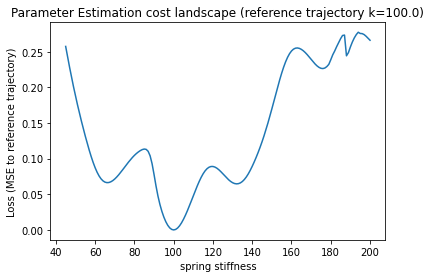

In [15]:
plt.title("Parameter Estimation cost landscape (reference trajectory k=100.0)")
plt.ylabel("Loss (MSE to reference trajectory)")
plt.xlabel("spring stiffness")
plt.plot(ks, losses);